Shows how one can generate text given a prompt and some hyperparameters, using either minGPT or huggingface/transformers

In [3]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

model_type = "distilbert/distilgpt2"
device = 'cuda'

model = GPT2LMHeadModel.from_pretrained(model_type, attn_implementation='eager')
model.config.pad_token_id = model.config.eos_token_id

model.to(device)
model.eval();

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [4]:
def generate(prompt='', num_samples=10, steps=20, do_sample=True):

    tokenizer = GPT2Tokenizer.from_pretrained(model_type)
    if prompt == '':
        prompt = '<|endoftext|>'
    encoded_input = tokenizer(prompt, return_tensors='pt').to(device)
    x = encoded_input['input_ids']
    attention_mask = encoded_input['attention_mask']

    x = x.expand(num_samples, -1)
    attention_mask = attention_mask.expand(num_samples, -1)

    y = model.generate(x, attention_mask=attention_mask, max_new_tokens=steps, do_sample=do_sample, top_k=40)

    for i in range(num_samples):
        out = tokenizer.decode(y[i].cpu().squeeze())
        print('-'*80)
        print(out)

generate(prompt='Once Upon a Time,', num_samples=1, steps=100)

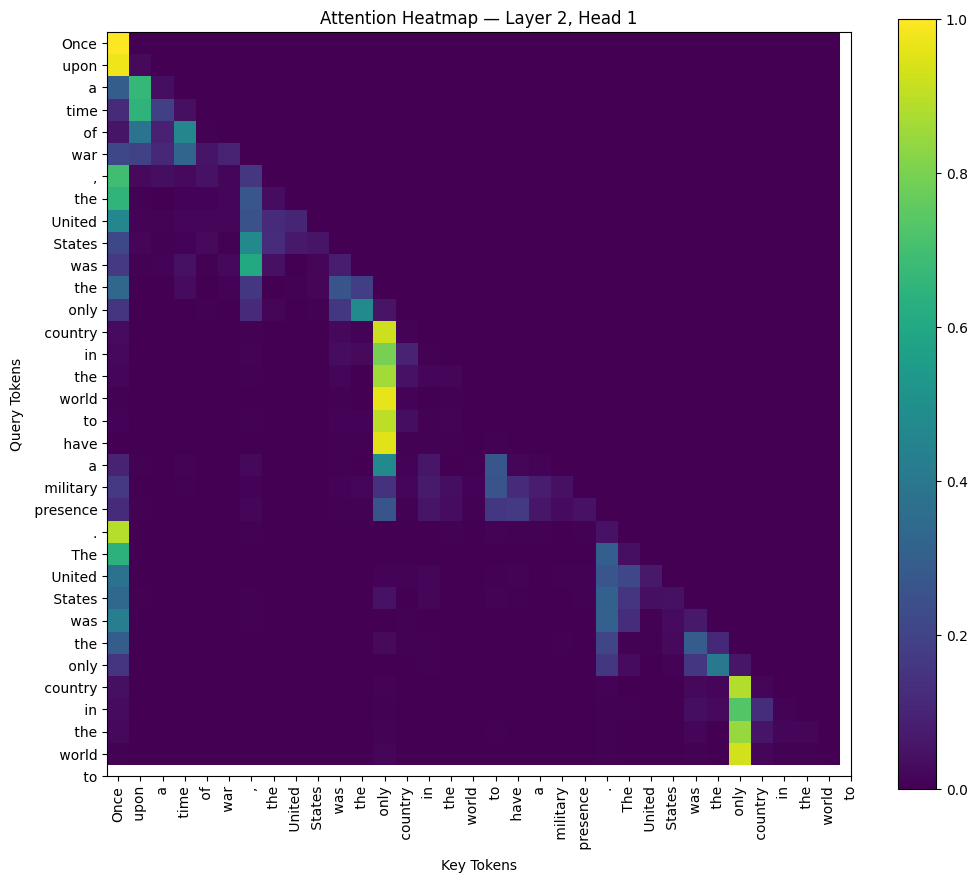

In [16]:
import matplotlib.pyplot as plt
import numpy as np

tokenizer = GPT2Tokenizer.from_pretrained(model_type)

prompt = "Once upon a time"
inputs = tokenizer(prompt, return_tensors="pt").to(device)

@torch.no_grad()
def generate_with_attention(model, tokenizer, prompt, max_new_tokens=40):
    model.config.output_attentions = True

    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

    all_tokens = input_ids.clone()
    all_attn = []

    for _ in range(max_new_tokens):
        outputs = model(all_tokens, use_cache=False)
        logits = outputs.logits
        attentions = outputs.attentions

        if attentions is None or not isinstance(attentions, tuple) or len(attentions) == 0:
            print("Warning: Model did not output attentions. Ensure model.config.output_attentions is True.")
            break

        attn_step = torch.stack([a[0] for a in attentions])
        all_attn.append(attn_step.cpu())

        next_id = torch.argmax(logits[:, -1, :], dim=-1, keepdim=True)
        all_tokens = torch.cat([all_tokens, next_id], dim=1)

        if next_id.item() == tokenizer.eos_token_id:
            break

    return all_tokens[0], all_attn

def clean(tokens):
    return [t.replace("Ġ", " ") for t in tokens]

tokens, attn_list = generate_with_attention(model, tokenizer, prompt, max_new_tokens=30)

decoded = tokenizer.decode(tokens)

def plot_full_attention(tokens, attn_list, layer=0, head=0):
    text_tokens = clean(tokenizer.convert_ids_to_tokens(tokens))

    if not attn_list:
        print("Error: attn_list is empty. No attention data to plot.")
        return

    final_step_attn = attn_list[-1]

    full_attn = final_step_attn[layer, head].numpy()

    plt.figure(figsize=(12, 10))
    plt.imshow(full_attn, cmap="viridis")
    plt.colorbar()
    plt.title(f"Attention Heatmap — Layer {layer}, Head {head}")
    plt.xlabel("Key Tokens")
    plt.ylabel("Query Tokens")
    plt.xticks(range(len(text_tokens)), text_tokens, rotation=90)
    plt.yticks(range(len(text_tokens)), text_tokens)
    plt.show()

plot_full_attention(tokens, attn_list, layer=2, head=1)


In [5]:
import os
import numpy as np
from torch.utils.data import DataLoader, Dataset
from transformers import GPT2TokenizerFast
from datasets import load_dataset

class TinyDataset(Dataset):
    def __init__(self, data, block_size):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return max(0, len(self.data) - self.block_size - 1)

    def __getitem__(self, idx):
        chunk = self.data[idx : idx + self.block_size + 1]
        x = torch.tensor(chunk[:-1], dtype=torch.long)
        y = torch.tensor(chunk[1:], dtype=torch.long)
        return x, y

subset_size = 10000
dataset = load_dataset("roneneldan/TinyStories", split=f"train[:{subset_size}]")
print("Stories loaded:", len(dataset))
encoded_file = "tinystories-encoded.npy"

if os.path.exists(encoded_file):
  print("Loading pre-tokenized dataset...")
  data = np.load(encoded_file).astype(np.int64)
else:
  print("Tokenizing dataset with BPE tokenizer...")
  tok = GPT2TokenizerFast.from_pretrained("gpt2")
  tok.pad_token = tok.eos_token
  ids_list = []
  for i, story in enumerate(dataset["text"]):
    ids = tok(story, return_tensors=None)["input_ids"]
    ids_list.extend(ids)
    ids_list.append(tok.eos_token_id)

    if (i + 1) % 5000 == 0:
        print(f"Processed {i+1:,} stories... total tokens: {len(ids_list):,}")

  data = np.array(ids_list, dtype=np.int32)
  np.save(encoded_file, data)

print("Total tokens in dataset:", len(data))

block_size = 128
tiny_ds = TinyDataset(data, block_size)
loader = DataLoader(tiny_ds, batch_size=8, shuffle=False)

if os.path.exists(encoded_file):
    os.remove(encoded_file)
    print("Removed:", encoded_file)

batch_size = 16
n = int(len(data) * 0.8)

val_ds = TinyDataset(data[n:], block_size)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00004-2d5a1467fff108(…):   0%|          | 0.00/249M [00:00<?, ?B/s]

data/train-00001-of-00004-5852b56a2bd28f(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/train-00002-of-00004-a26307300439e9(…):   0%|          | 0.00/246M [00:00<?, ?B/s]

data/train-00003-of-00004-d243063613e5a0(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/validation-00000-of-00001-869c898b5(…):   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

Stories loaded: 10000
Tokenizing dataset with BPE tokenizer...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1106 > 1024). Running this sequence through the model will result in indexing errors


Processed 5,000 stories... total tokens: 1,033,087
Processed 10,000 stories... total tokens: 2,162,078
Total tokens in dataset: 2162078
Removed: tinystories-encoded.npy


In [6]:
import numpy as np
import torch.nn.functional as F
import math

def evaluate_model(model, loader, device="cuda"):
    model.eval()

    total_loss = 0
    total_tokens = 0

    correct = 0
    total = 0

    top5_correct = 0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x).logits
            B, T, V = logits.shape

            loss = F.cross_entropy(
                logits.reshape(-1, V),
                y.reshape(-1),
                reduction="sum"
            )
            total_loss += loss.item()
            total_tokens += (B * T)

            preds = logits.argmax(dim=-1)
            correct += (preds == y).sum().item()
            total += y.numel()

            top5 = logits.topk(5, dim=-1).indices
            in_top5 = (top5 == y.unsqueeze(-1)).any(dim=-1)
            top5_correct += in_top5.sum().item()

    avg_loss = total_loss / total_tokens
    ppl = math.exp(avg_loss)
    acc = correct / total
    top5_acc = top5_correct / total

    return {
        "perplexity": ppl,
        "token_accuracy": acc,
        "top5_accuracy": top5_acc
    }

metrics = evaluate_model(model, val_loader, device="cuda")

print("\nValidation Metrics:")
for k, v in metrics.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v}\n")